<h1> DS200A Computer Vision Assignment</h1>

<h2>  Part Two: Exploratory data analysis and feature extraction. </h2>	


<h5> In this section, Compute at least 15 such image features (a method for each), including the following (NOTE: At least 10 of these must be scalar features and 2 matrix-based features): (i) image size, (ii) average of the red-channel intensity, (iii) aspectratio. This will require significant explatoratory research and data analysis. The first one is already implemented for you, and the next two are pre-specified. Additional requirements specfied in pdf. </h5>

In [1]:
# Mount Google Drive when working on Google Colab
try:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd "/content/drive/My Drive/computer_vision"
    %pwd
    %ls
except:
    pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/computer_vision
 20_categories_training/    X_test_tensor.pt
 20_Validation/             X_training_bovw_c150.pkl
 3034503889,24149494.mp4    X_training_bovw_c250.pkl
 bovw_vectorizer.pkl        X_training_bovw_c50.pkl
 cifar/                     X_training_bovw_c64.pkl
 figures/                   X_training_bovw_c791.pkl
 GradProject_NB1.ipynb      X_training_combined.pkl
 GradProject_NB2.ipynb      X_training.pkl
 GradProject_NB3.ipynb      X_train_tensor.pt
 GradProject_NB4.ipynb      X_train_tensor_standardized.pt
 imagenet20/                X_unlabeled.pkl
 model_utils.py             Y_nn_test.pkl
 nn_prediction.csv          Y_nn_train.pkl
 prediction.csv             Y_testing_bovw_c150.pkl
'Project Narrative.ipynb'   Y_testing_bovw_c250.pkl
 __pycache__/               Y_testing_bovw_c50.pkl
 requirements.txt           Y_testing_b

In [2]:
!pip uninstall -y opencv-python
!pip uninstall -y opencv-contrib-python
!pip install --no-input opencv-contrib-python==4.4.0.44
!pip install mahotas
!pip install featexp

Uninstalling opencv-contrib-python-4.4.0.44:
  Successfully uninstalled opencv-contrib-python-4.4.0.44
  Using cached https://files.pythonhosted.org/packages/a7/25/d4aa87bb9279127f1bac881b7524d8bafd25d626aba2c28fa355ed1ada2a/opencv_contrib_python-4.4.0.44-cp36-cp36m-manylinux2014_x86_64.whl


In [3]:
import sys
sys.path.append("./model_utils.py")


from model_utils import BOVWVectorizer, class_names

import pandas as pd
import skimage
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from skimage import io
from PIL import Image
from skimage.color import rgb2gray
from skimage.io import imshow
from skimage import feature
import cv2
import mahotas
import pickle

%load_ext autoreload

%autoreload 2

sns.set()
%config InlineBackend.figure_format = 'retina'

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
training_data = pd.read_pickle('training_data.pkl')
training_data = training_data.reset_index(drop=True)

testing_data = pd.read_pickle('testing_data.pkl')
testing_data = testing_data.reset_index(drop=True)

print("Training data:", training_data.shape)
print("Testing data:", testing_data.shape)

Training data: (1200, 2)
Testing data: (301, 2)


## Display Three Sample Pictures

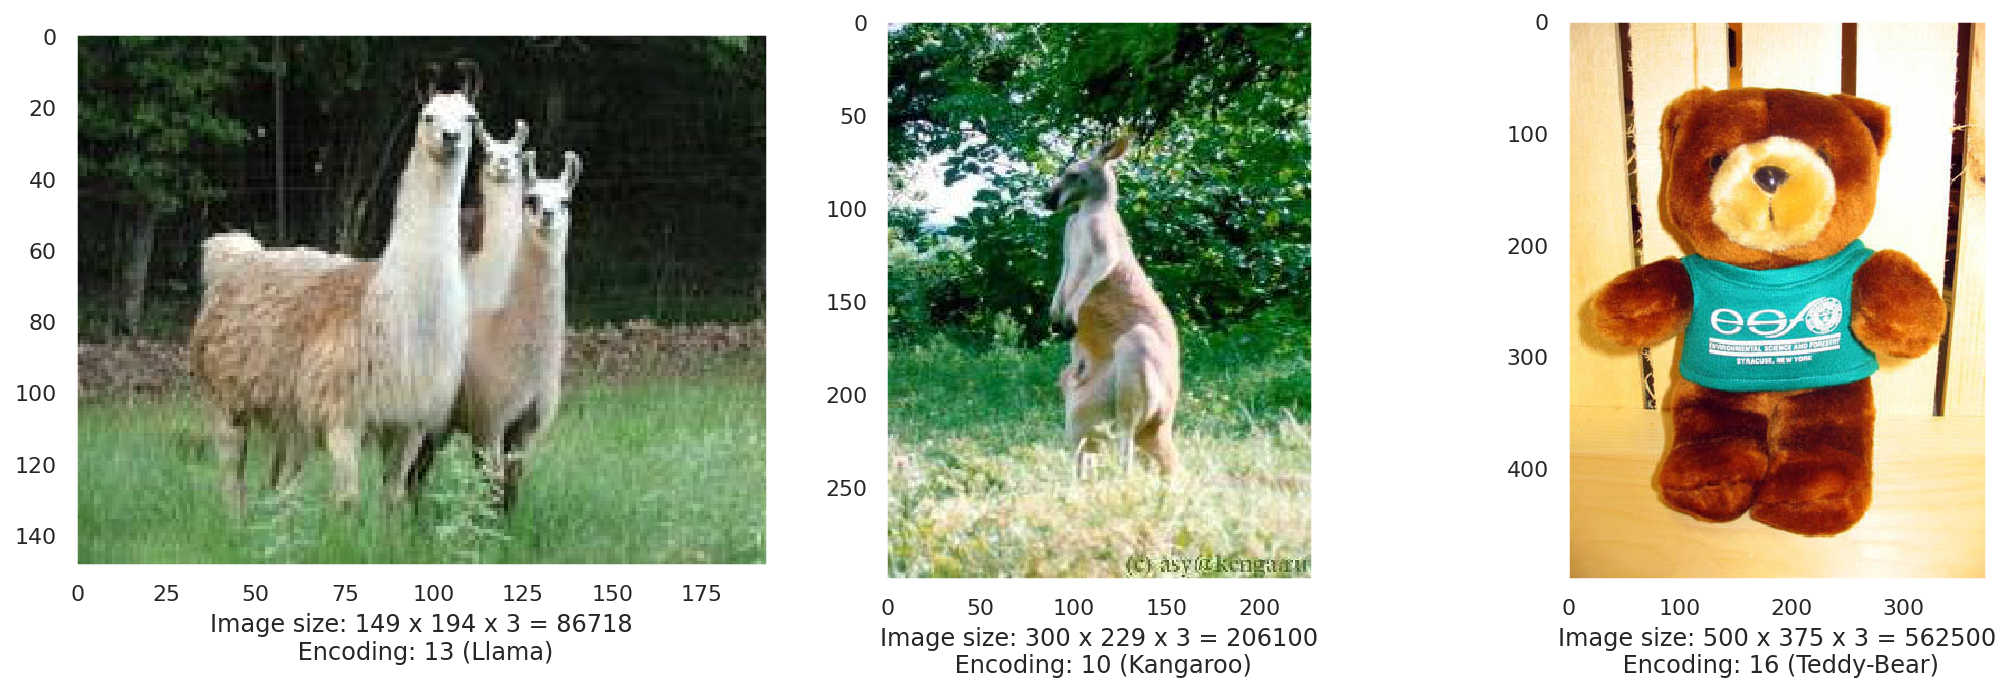

In [5]:
# Visualize three random images
samples = training_data.sample(n=3).reset_index()
plt.figure(figsize=(15,5))
for i in range(3):
    pic = samples.loc[i,'Pictures']
    fig = plt.subplot(1,3,i+1)
    fig.grid(False)
    skimage.io.imshow(pic)
    fig.set_xlabel(f'Image size: {pic.shape[0]} x {pic.shape[1]} x ' +
    f'{pic.shape[2]} = {pic.size}\n Encoding: {samples.loc[i,"Encoding"]} '+
    f'({class_names[samples.loc[i,"Encoding"]]})')

It seems that the pictures are correctly read and labeled. Next, let's do some exploratory data analysis.

## Graphic Summaries of Some Features

First, check the sizes of the images. In addition, we visualize the heights and widths of the images.

Min size: 36915 Max size: 10584000 Mean size: 499727.9775
Min height: 105 Max height: 2048 Mean height: 334.0391666666667
Min width: 115 Max width: 2100 Mean width: 396.61


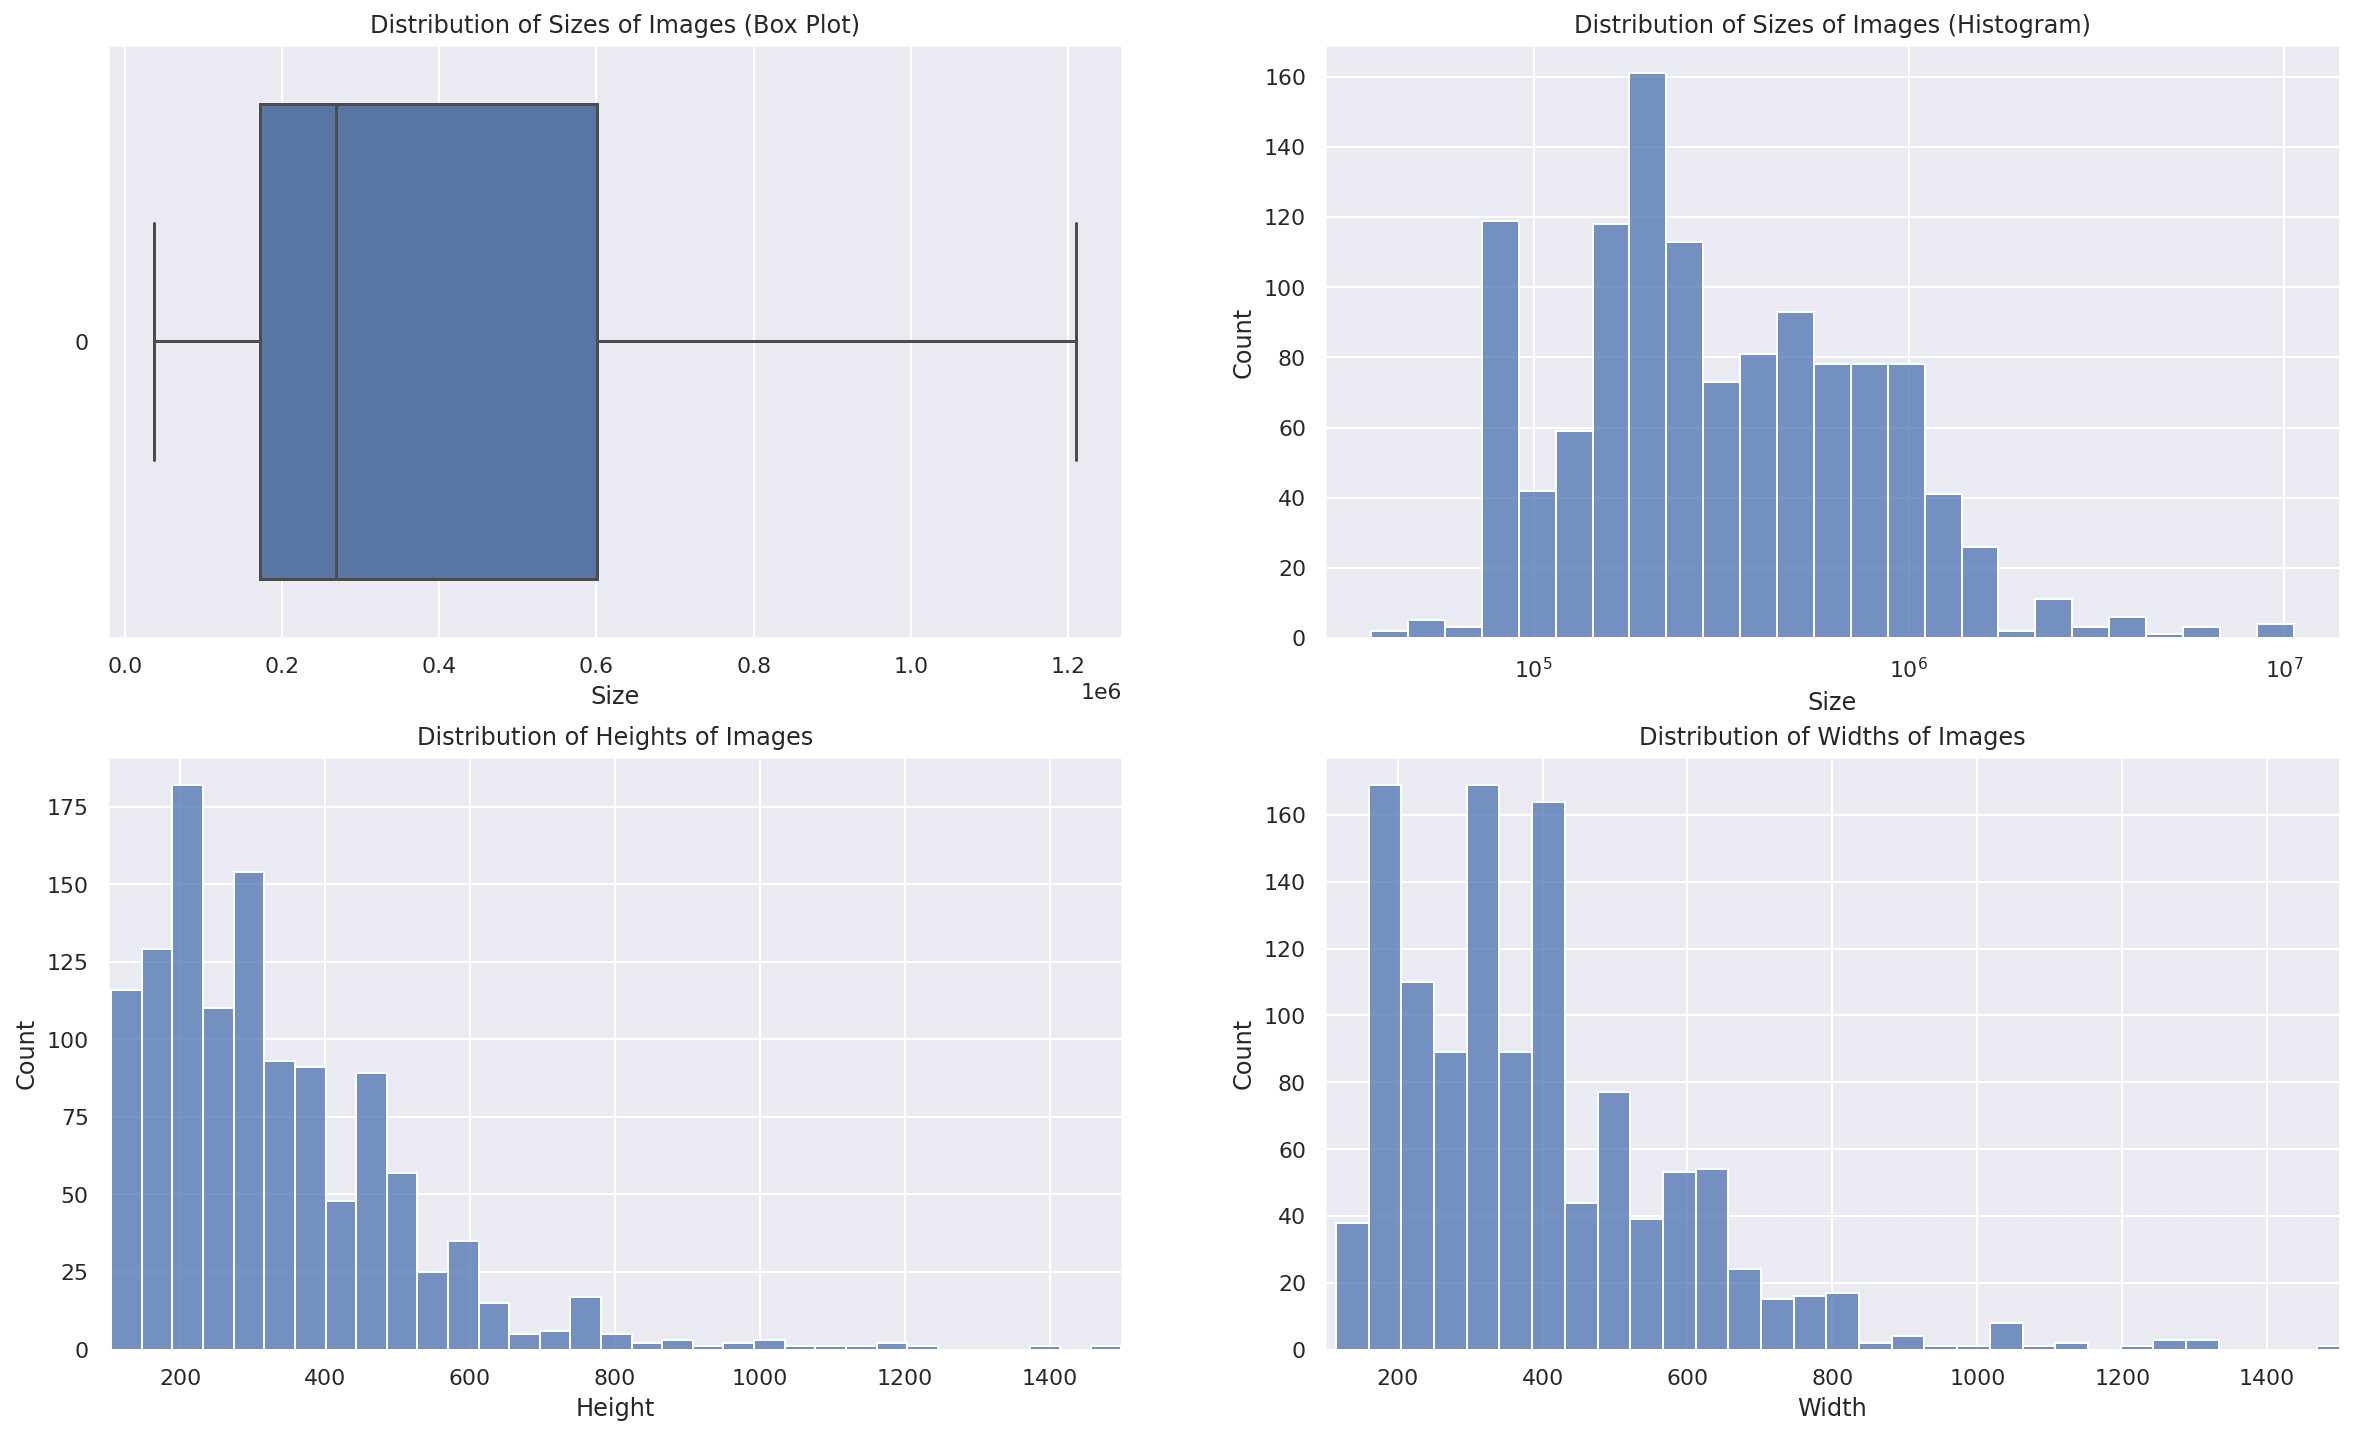

In [6]:
sizes = training_data['Pictures'].apply(lambda x:x.size)
heights = training_data['Pictures'].apply(lambda x:x.shape[0])
widths = training_data['Pictures'].apply(lambda x:x.shape[1])

print("Min size:", sizes.min(), "Max size:", sizes.max(), "Mean size:", sizes.mean())
print("Min height:", heights.min(), "Max height:", heights.max(), "Mean height:", heights.mean())
print("Min width:", widths.min(), "Max width:", widths.max(), "Mean width:", widths.mean())

plt.figure(figsize=(20,12))

plt.subplot(2,2,1)
sns.boxplot(data=sizes.values, showfliers=False, orient='h');
plt.xlabel('Size')
plt.ylabel('')
plt.title('Distribution of Sizes of Images (Box Plot)')

plt.subplot(2,2,2)
sns.histplot(sizes.values, log_scale=True)
plt.xlabel('Size')
plt.ylabel('Count')
plt.title('Distribution of Sizes of Images (Histogram)');

plt.subplot(2,2,3)
sns.histplot(heights.values)
plt.xlabel('Height')
plt.ylabel('Count')
plt.xlim(100, 1500)
plt.title('Distribution of Heights of Images');

plt.subplot(2,2,4)
sns.histplot(widths.values)
plt.xlim(100, 1500)
plt.xlabel('Width')
plt.ylabel('Count')
plt.title('Distribution of Widths of Images');

plt.savefig('figures/summary_sizes.png')

We found that there are outliers in the size, width, and height distributions. The sizes of images have a large variance. The largest image is over 500 times as large as the smallest one! Let's visualize some of the outliers to make sure they are legit pictures.

In [7]:
training_data['sizes'] = sizes
plt.figure(figsize=(15,5))
i=0
for idx,img in training_data.sort_values('sizes',ascending=False).head(3)['Pictures'].items():
    print(idx)
    plt.subplot(1,3,i+1)
    plt.grid(False)
    io.imshow(img)
    i+=1

Output hidden; open in https://colab.research.google.com to view.

We can see that the outliers are not due to errors! Some features are heavily influenced by image size. We should use resize images before extracting these features. We choose (256, 256) as the destination image size, slightly smaller than the average size.

Now, let's check the distribution of pixel intensities.

In [8]:
pixel_intensities_mean = training_data['Pictures'].apply(np.mean)
pixel_intensities_std = training_data['Pictures'].apply(np.std)
pixel_intensities_mean_red = training_data['Pictures'].apply(lambda x: np.mean(x[...,0]))
pixel_intensities_std_red = training_data['Pictures'].apply(lambda x: np.std(x[...,0]))
pixel_intensities_mean_green = training_data['Pictures'].apply(lambda x: np.mean(x[...,1]))
pixel_intensities_std_green = training_data['Pictures'].apply(lambda x: np.std(x[...,1]))
pixel_intensities_mean_blue = training_data['Pictures'].apply(lambda x: np.mean(x[...,2]))
pixel_intensities_std_blue = training_data['Pictures'].apply(lambda x: np.std(x[...,2]))

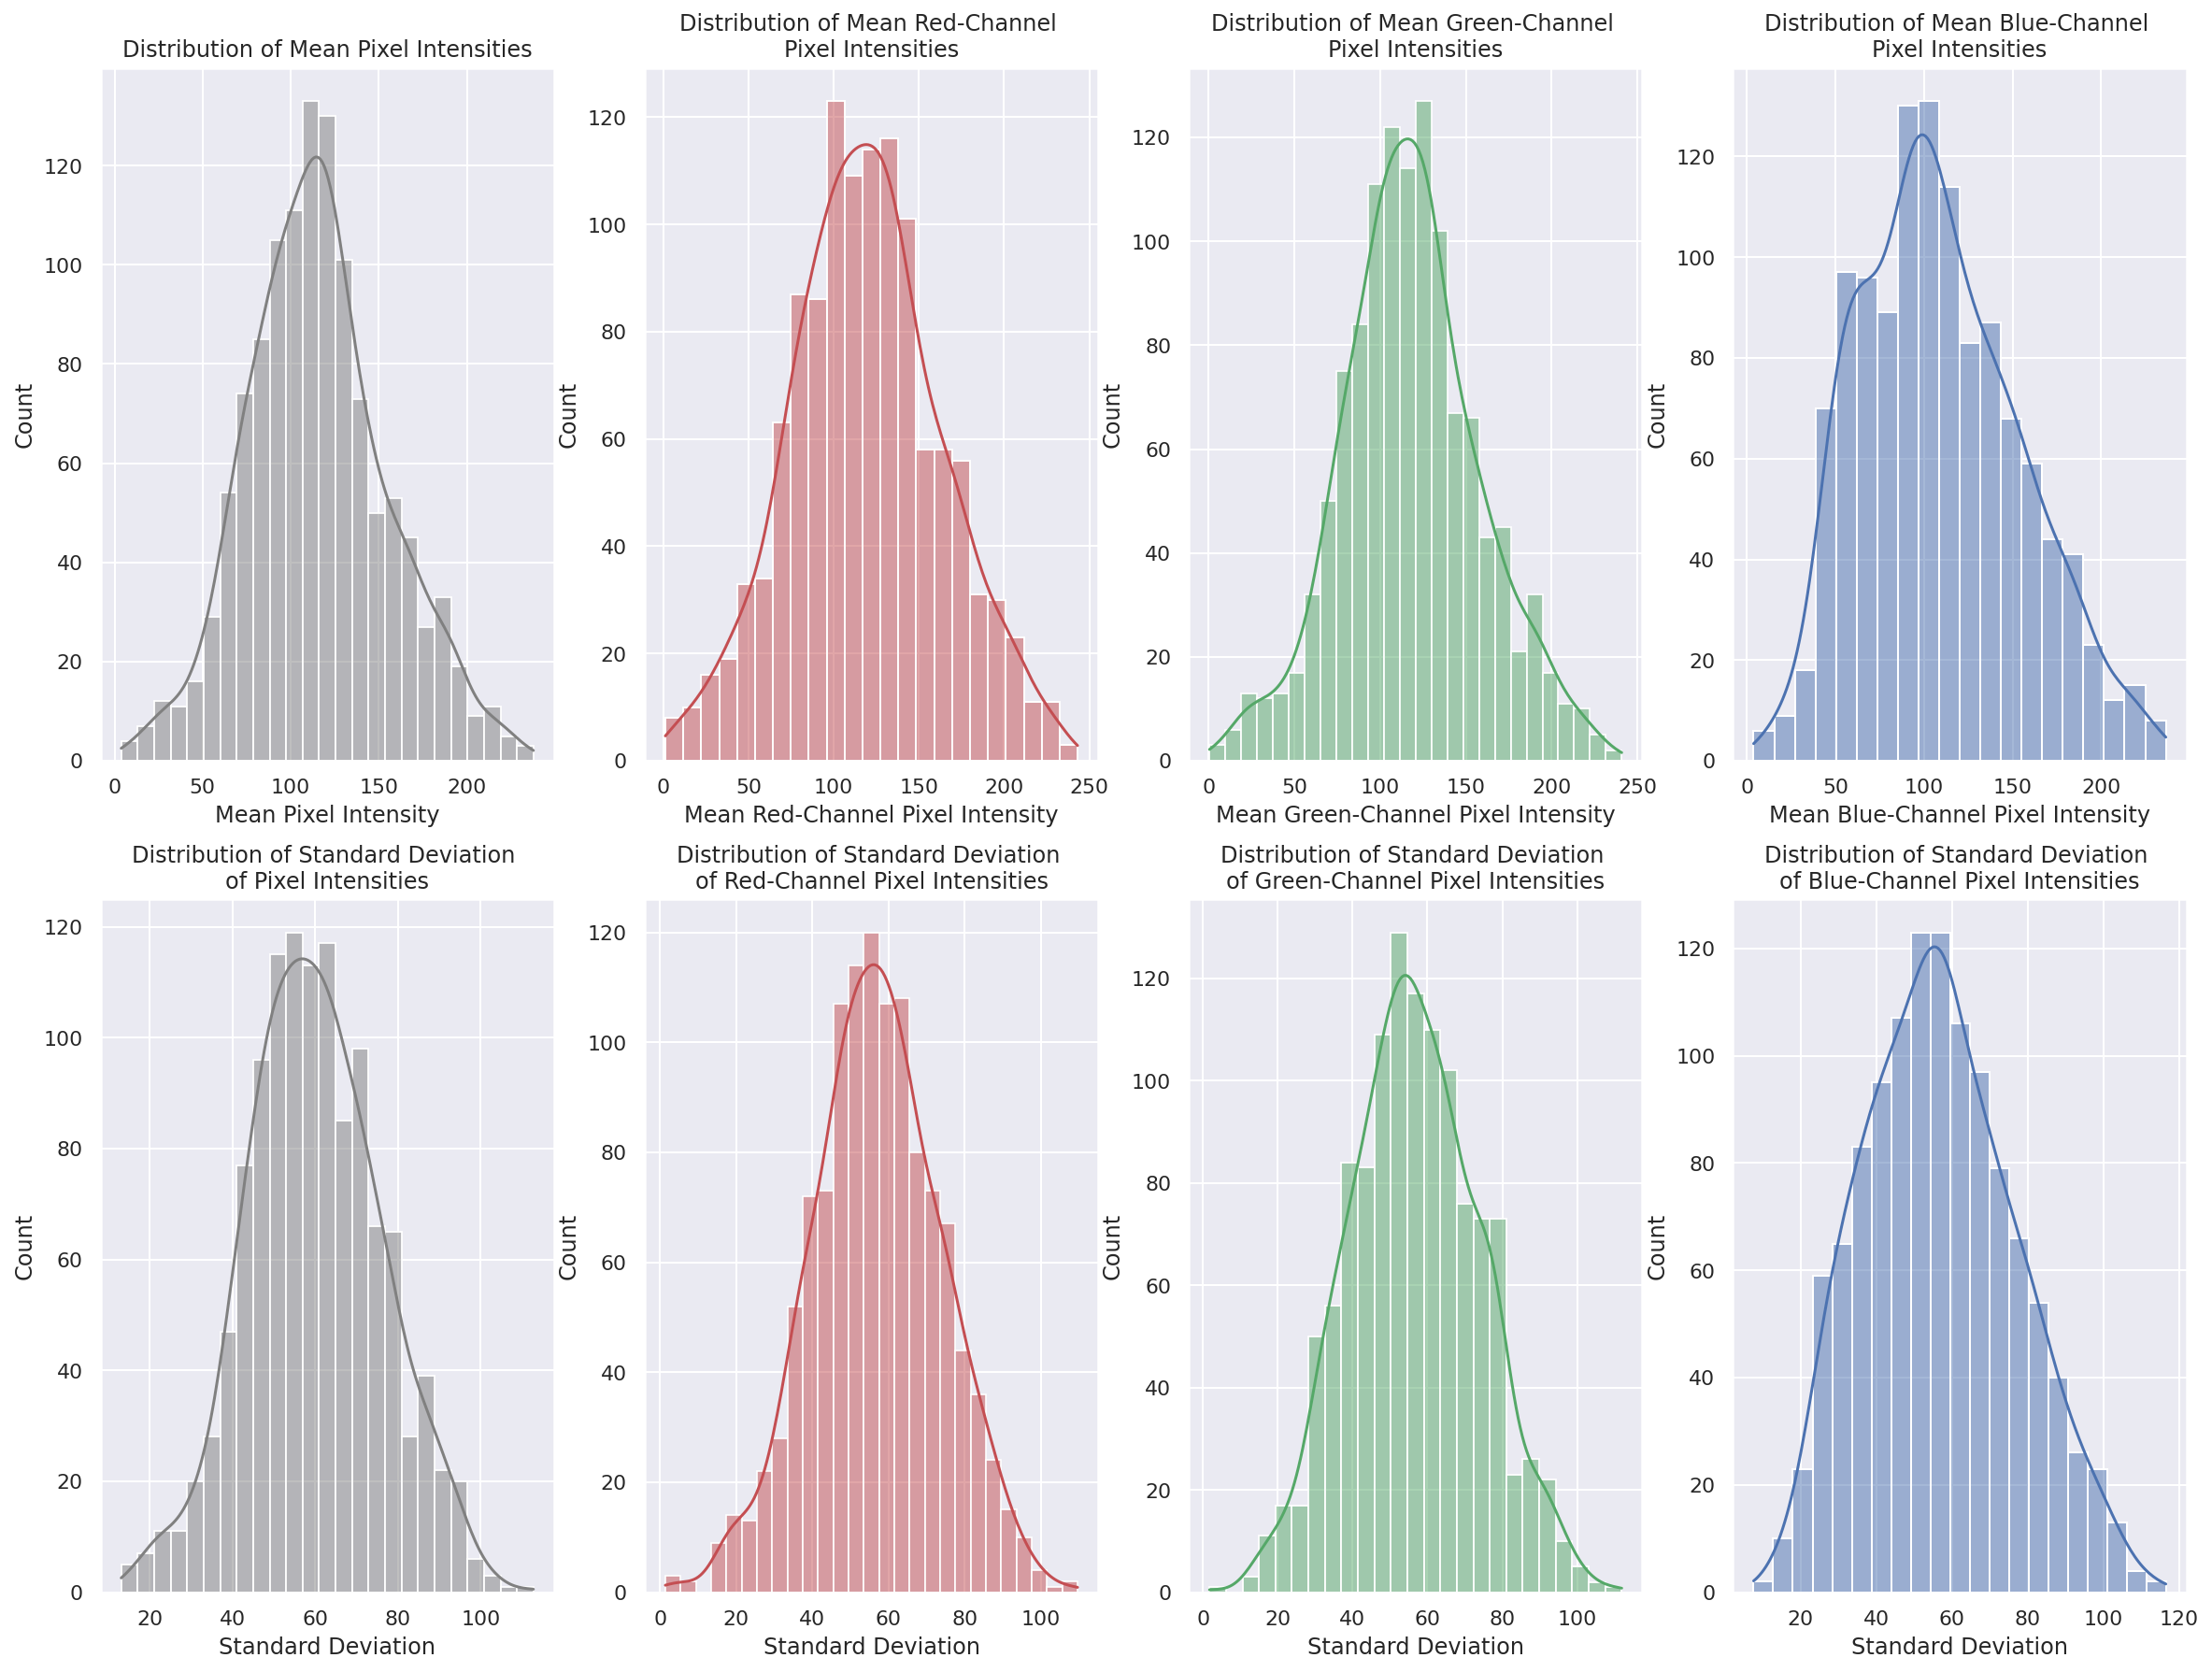

In [9]:
plt.figure(figsize=(20,15))

plt.subplot(2,4,1)
sns.histplot(pixel_intensities_mean, kde=True, color='gray');
plt.xlabel('Mean Pixel Intensity')
plt.ylabel('Count')
plt.title('Distribution of Mean Pixel Intensities');

plt.subplot(2,4,2)
sns.histplot(pixel_intensities_mean_red, kde=True, color='r');
plt.xlabel('Mean Red-Channel Pixel Intensity')
plt.ylabel('Count')
plt.title('Distribution of Mean Red-Channel \nPixel Intensities');

plt.subplot(2,4,3)
sns.histplot(pixel_intensities_mean_green, kde=True, color='g');
plt.xlabel('Mean Green-Channel Pixel Intensity')
plt.ylabel('Count')
plt.title('Distribution of Mean Green-Channel \nPixel Intensities');

plt.subplot(2,4,4)
sns.histplot(pixel_intensities_mean_blue, kde=True, color='b');
plt.xlabel('Mean Blue-Channel Pixel Intensity')
plt.ylabel('Count')
plt.title('Distribution of Mean Blue-Channel \nPixel Intensities');

plt.subplot(2,4,5)
sns.histplot(pixel_intensities_std, kde=True, color='gray');
plt.xlabel('Standard Deviation')
plt.ylabel('Count')
plt.title('Distribution of Standard Deviation \nof Pixel Intensities');

plt.subplot(2,4,6)
sns.histplot(pixel_intensities_std_red, kde=True, color='r');
plt.xlabel('Standard Deviation')
plt.ylabel('Count')
plt.title('Distribution of Standard Deviation \nof Red-Channel Pixel Intensities');

plt.subplot(2,4,7)
sns.histplot(pixel_intensities_std_green, kde=True, color='g');
plt.xlabel('Standard Deviation')
plt.ylabel('Count')
plt.title('Distribution of Standard Deviation \nof Green-Channel Pixel Intensities');

plt.subplot(2,4,8)
sns.histplot(pixel_intensities_std_blue, kde=True, color='b');
plt.xlabel('Standard Deviation')
plt.ylabel('Count')
plt.title('Distribution of Standard Deviation \nof Blue-Channel Pixel Intensities');

plt.savefig('figures/summary_pixel_intensities.png')

The distribution of mean and standard deviation of pixel intensities are all similar to normal distribution in each individual channels and the average of all channels. The distribution of mean values are all slightly right skewed, and the standard deviation in the blue channel is also slightly right skewed.

Then, we check the frequencies of classes.

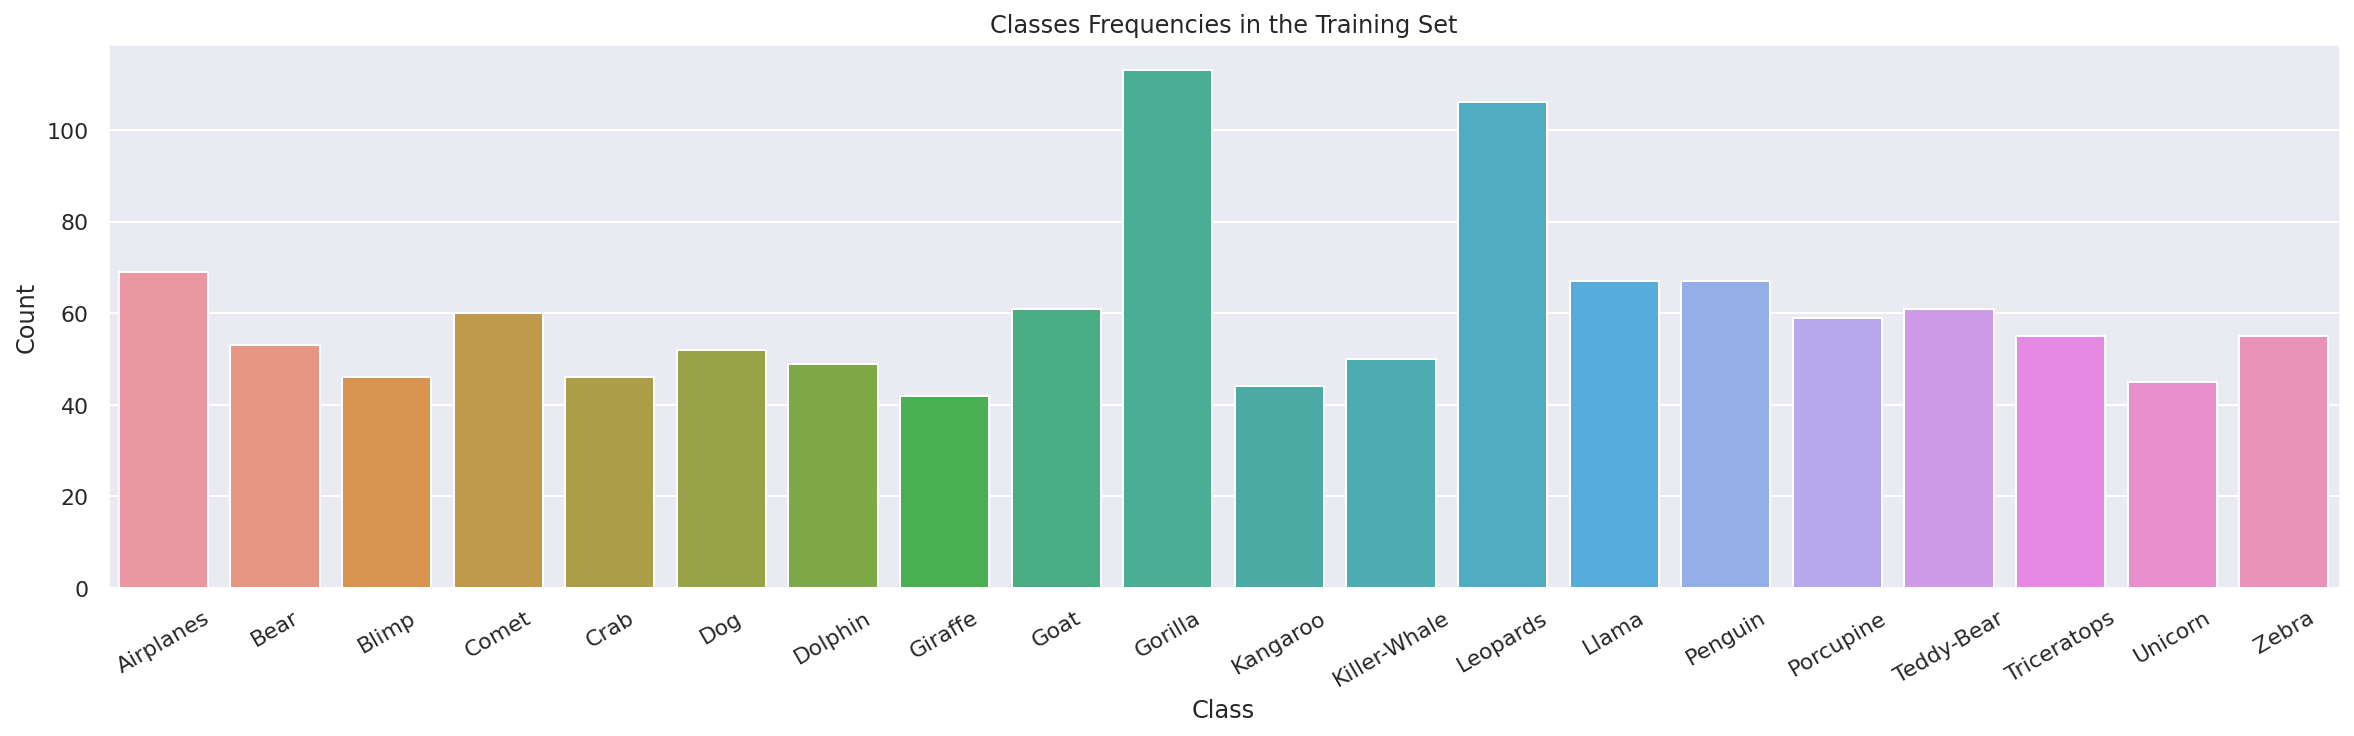

In [10]:
class_frequencies = training_data['Encoding'].value_counts().sort_index()
plt.figure(figsize=(20,5))
g = sns.barplot(x=class_names, y=class_frequencies);
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Classes Frequencies in the Training Set')
g.set_xticklabels(class_names, rotation=30);
plt.savefig('figures/summary_class_frequencies.png')

The class distribution in the training set is uneven, with Gorilla and Leopards classes have significantly more images than others. However, the difference is still acceptable, because the number of images in each class is on the same magnitude. We do not want to remove any data due to the small size of the dataset.

## Feature Extraction

Next, we extract features from images. As we said above, some features are extracted from original images directly, while others are extracted from resized images.

In [11]:
imsize = (256,256) # Image size after resizing
# Compute image features
original_image_features = [] # features calculated from original images directly
resized_image_features = [] # features extracted from resized images
matrix_based_features = [] # features that we need to unpack.

def ft_size(image):
    """Returns the pixel size of the image
    """
    return image.size
original_image_features.append(ft_size)

def ft_red_avg(image):
    """Returns the average of the red-channel intensity for the images
    """
    return image[...,0].mean()
original_image_features.append(ft_red_avg)

def ft_aspect_ratio(image):
    """Returns the aspect ratio of the image
    """
    return image.shape[1] / image.shape[0]
original_image_features.append(ft_aspect_ratio)

def ft_green_avg(image):
    """Returns the average of the green-channel intensity for the images
    """
    return image[...,1].mean()
original_image_features.append(ft_green_avg)

def ft_blue_avg(image):
    """Returns the average of the blue-channel intensity for the images
    """
    return image[...,2].mean()
original_image_features.append(ft_blue_avg)

def ft_red_std(image):
    """Returns the standard deviation of the red-channel intensity for the images
    """
    return image[...,0].var()
original_image_features.append(ft_red_std)

def ft_green_std(image):
    """Returns the standard deviation of the green-channel intensity for the images
    """
    return image[...,1].var()
original_image_features.append(ft_green_std)

def ft_blue_std(image):
    """Returns the standard deviation of the blue-channel intensity for the images
    """
    return image[...,2].var()
original_image_features.append(ft_blue_std)

def ft_red_proportion(image):
    """Returns the proportion of the pixels where red-channel intensity is 
    higher than green- and blue-channel intensities for the images
    """
    return (image[...,0]>np.maximum(image[...,1],image[...,2])).mean()
original_image_features.append(ft_red_proportion)

def ft_green_proportion(image):
    """Returns the proportion of the pixels where green-channel intensity is 
    higher than red- and blue-channel intensities for the images
    """
    return (image[...,1]>np.maximum(image[...,0],image[...,2])).mean()
original_image_features.append(ft_green_proportion)

def ft_blue_proportion(image):
    """Returns the proportion of the pixels where blue-channel intensity is 
    higher than red- and green-channel intensities for the images
    """
    return (image[...,2]>np.maximum(image[...,0],image[...,1])).mean()
original_image_features.append(ft_blue_proportion)

def ft_harris_avg(image):
    """Returns mean value of Harris Corner Detection Results on the image
    """
    image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    return cv2.cornerHarris(image,2,3,0.04).mean()
resized_image_features.append(ft_harris_avg)

def ft_harris_std(image):
    """Returns standard deviation of Harris Corner Detection Results on the image
    """
    image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    return cv2.cornerHarris(image,2,3,0.04).std()
resized_image_features.append(ft_harris_std)

def ft_corner_count(image):
    """Returns number of corners returned by Shi-Tomasi method
    """
    image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    return len(cv2.goodFeaturesToTrack(image,64,0.01,10))
resized_image_features.append(ft_corner_count)

def ft_color_histogram(image, bins=4):
    """Returns color histograms of the image
    """
    # convert the image to HSV color-space
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # compute the color histogram
    hist  = cv2.calcHist([image], [0, 1, 2], None, [bins, bins, bins], [0, 256, 0, 256, 0, 256])
    # normalize the histogram
    cv2.normalize(hist, hist)
    # return the histogram
    return hist.flatten()
resized_image_features.append(ft_color_histogram)
matrix_based_features.append(ft_color_histogram)

def ft_hu_moments(image):
    """Returns Hu moments of the image
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature.flatten()
resized_image_features.append(ft_hu_moments)
matrix_based_features.append(ft_hu_moments)

def ft_haralick(image):
    """Returns Haralick Texture of the image
    """
    # convert the image to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    feature = mahotas.features.haralick(image).mean(axis=0)
    # return the result
    return feature.flatten()
resized_image_features.append(ft_haralick)
matrix_based_features.append(ft_haralick)

def ft_zernike(image, radius=10):
    """Returns zernike moments of the image
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = mahotas.features.zernike_moments(image, 10)
    return feature.flatten()
resized_image_features.append(ft_zernike)
matrix_based_features.append(ft_zernike)

sift = cv2.SIFT_create()
def ft_sift(image):
    """Returns SIFT descriptors for the images for each keypoint discovered.
    This routine is different from ft_sift_avg in two ways:
    - uses cv2.xfeatures2d.SIFT_create() 
    - also does not convert to greyscale
    Used in BoVW
    """
    image = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    kps, des = sift.detectAndCompute(image, None)
    return des
# used in BoVW

def ft_tas(image):
    """Returns threshold adjacency statistics of the image
    Not used, can cause overfitting
    """
    feature = mahotas.features.tas(image)
    return feature.flatten()
# resized_image_features.append(ft_tas)
# matrix_based_features.append(ft_tas)

In [12]:
print(len(original_image_features))
print(len(resized_image_features))
print(len(matrix_based_features))

11
7
4


<h4> DataFrame Creation </h4>

In [13]:
def feature_frame(df, imsize=(64,64)):
    """Creates the feature matrix from the training dataframe of images 
    """
    # resize all the images to one size
    df['ResizedPictures'] = df['Pictures'].apply(lambda img:cv2.resize(img, imsize))
    
    features = {}
    for ft in original_image_features:
        print('Extracting feature: ' + ft.__name__)
        features[ft.__name__] = df['Pictures'].apply(ft)
    for ft in resized_image_features:
        if ft in matrix_based_features:
            print('Extracting feature: ' + ft.__name__ + ', length ' + str(ft(df.loc[0, 'ResizedPictures']).size))
            for i, f in enumerate(np.array(df['ResizedPictures'].apply(ft).to_list()).T):
                features[ft.__name__+str(i)] = f
        else:
            features[ft.__name__] = df['ResizedPictures'].apply(ft)
    return pd.DataFrame(features)
    #Returns data-frame with all the features now inside, and calculated

def bovw_feature_frame(df, vectorizer, num_clusters=None, imsize=(256, 256), mode='train'):
    resized_images = df['Pictures'].apply(lambda img: cv2.resize(img, imsize))
    if mode == 'train':
        features = bovw.fit_transform(resized_images, num_clusters)
    elif mode == 'test':
        features = bovw.transform(resized_images)
    bovw_cols = list(map(lambda i: "bovw"+"_"+str(i), range(features.shape[1])))
    return pd.DataFrame(features, columns=bovw_cols)
    

Before we generate the design matrix, we should examine if all features are applicable. After reading documentation, we notice that SIFT does not always produce results. So we check how many pictures are problemetic.

In [14]:
def compute_all_sift_features(images, cleaning=False):
    no_sift_counter = 0
    descs = []
    indices = []
    for i, img in enumerate(images, 0):
        des = ft_sift(img)
        if isinstance(des, type(None)) or not des.any() or des.size == 0:
            print("null sift image idx: {}".format(i))
            no_sift_counter += 1
            indices.append(i)
            continue
        descs.append(des)
    if cleaning:
        print("{} images are problematic.".format(no_sift_counter, indices))
        return np.vstack(descs), indices
    else:
        return np.vstack(descs)
unlabeled_data = pd.read_pickle('unlabeled_data.pkl')
resized_unlabeled = unlabeled_data['Pictures'].apply(lambda img: cv2.resize(img, imsize))
compute_all_sift_features(resized_unlabeled, cleaning=True);

0 images are problematic.


Seems that all unlabeled images have SIFT keypoints. Let's check our labeled data.

In [15]:
# INSPECT THE TRAINING DATASET AND DROP THE PROBLEMATIC IMAGE (THERE IS ONLY 1)

resized_training = training_data['Pictures'].apply(lambda img: cv2.resize(img, imsize))
all_sift_features, problemetic_indices = compute_all_sift_features(resized_training, cleaning=True)
training_data_cleaned = training_data.drop(index=problemetic_indices).reset_index(drop=True)

null sift image idx: 1002
1 images are problematic.


In [16]:
resized_testing = testing_data['Pictures'].apply(lambda img: cv2.resize(img, imsize))
all_sift_features, problemetic_indices = compute_all_sift_features(resized_testing, cleaning=True)
testing_data_cleaned = testing_data.drop(index=problemetic_indices).reset_index(drop=True)

0 images are problematic.


Only one image in training set does not have any keypoints. We do not want to add more category to include just one image. So, we dropped it.

In [17]:
# THIS WILL TAKE SOME TIME
# RUN THIS ONLY WHEN YOU HAVE TO

# THIS WILL CREATE BAG OF VISUAL WORDS FEATURE MATRIX FOR A GIVEN NUM CLUSTER SIZE

# from model_utils import BOVWVectorizer
# bovw = BOVWVectorizer()
# num_clusters = 250
# X_training_bovw = bovw_feature_frame(training_data_cleaned, vectorizer=bovw, num_clusters=num_clusters, mode='train')
# X_testing_bovw = bovw_feature_frame(testing_data_cleaned, vectorizer=bovw, mode='test')
# with open('bovw_vectorizer.pkl', 'wb') as f:
#     pickle.dump(bovw, f)
# X_training_bovw.to_pickle('X_training_bovw_c{}.pkl'.format(num_clusters))
# Y_training_bovw.to_pickle('Y_training_bovw_c{}.pkl'.format(num_clusters))
# X_testing_bovw.to_pickle('X_testing_bovw_c{}.pkl'.format(num_clusters))
# Y_testing_bovw.to_pickle('Y_testing_bovw_c{}.pkl'.format(num_clusters))

In [18]:
with open('bovw_vectorizer.pkl', 'rb') as f:
    bovw = pickle.load(f)
X_training_bovw = bovw_feature_frame(training_data_cleaned, vectorizer=bovw, mode='test')
X_testing_bovw = bovw_feature_frame(testing_data_cleaned, vectorizer=bovw, mode='test')

In [19]:
X_training = feature_frame(training_data_cleaned)
Y_training = training_data_cleaned['Encoding']
X_testing = feature_frame(testing_data_cleaned)
Y_testing = testing_data_cleaned['Encoding']

# READ THE PREVIOUSLY GENERATED BOVW FEATURES

# n_clusters = 250
# X_training_bovw = pd.read_pickle('X_training_bovw_c{}.pkl'.format(n_clusters)) 
# Y_training_bovw = pd.read_pickle('Y_training_bovw_c{}.pkl'.format(n_clusters))
# X_training.reset_index(drop=True, inplace=True)
# Y_training.reset_index(drop=True, inplace=True)

# Read testing data
# X_testing_bovw = pd.read_pickle('X_testing_bovw_c{}.pkl'.format(n_clusters))
# Y_testing_bovw = pd.read_pickle('Y_testing_bovw_c{}.pkl'.format(n_clusters))
# X_testing.reset_index(drop=True, inplace=True)
# Y_testing.reset_index(drop=True, inplace=True)

Extracting feature: ft_size
Extracting feature: ft_red_avg
Extracting feature: ft_aspect_ratio
Extracting feature: ft_green_avg
Extracting feature: ft_blue_avg
Extracting feature: ft_red_std
Extracting feature: ft_green_std
Extracting feature: ft_blue_std
Extracting feature: ft_red_proportion
Extracting feature: ft_green_proportion
Extracting feature: ft_blue_proportion
Extracting feature: ft_color_histogram, length 64
Extracting feature: ft_hu_moments, length 7
Extracting feature: ft_haralick, length 13
Extracting feature: ft_zernike, length 25
Extracting feature: ft_size
Extracting feature: ft_red_avg
Extracting feature: ft_aspect_ratio
Extracting feature: ft_green_avg
Extracting feature: ft_blue_avg
Extracting feature: ft_red_std
Extracting feature: ft_green_std
Extracting feature: ft_blue_std
Extracting feature: ft_red_proportion
Extracting feature: ft_green_proportion
Extracting feature: ft_blue_proportion
Extracting feature: ft_color_histogram, length 64
Extracting feature: ft_hu

In [20]:
X_training_combined = pd.concat([X_training, X_training_bovw], axis=1)
X_testing_combined = pd.concat([X_testing, X_testing_bovw], axis=1)
X_training_combined.shape, Y_training.shape, X_testing_combined.shape, Y_testing.shape

((1199, 373), (1199,), (301, 373), (301,))

In [21]:
X_unlabeled = feature_frame(unlabeled_data)
X_unlabeled_bovw = bovw_feature_frame(unlabeled_data, vectorizer=bovw, mode='test')
X_unlabeled_combined = pd.concat([X_unlabeled, X_unlabeled_bovw], axis=1)
X_unlabeled_combined.to_pickle('X_unlabeled.pkl')

Extracting feature: ft_size
Extracting feature: ft_red_avg
Extracting feature: ft_aspect_ratio
Extracting feature: ft_green_avg
Extracting feature: ft_blue_avg
Extracting feature: ft_red_std
Extracting feature: ft_green_std
Extracting feature: ft_blue_std
Extracting feature: ft_red_proportion
Extracting feature: ft_green_proportion
Extracting feature: ft_blue_proportion
Extracting feature: ft_color_histogram, length 64
Extracting feature: ft_hu_moments, length 7
Extracting feature: ft_haralick, length 13
Extracting feature: ft_zernike, length 25


In [22]:
# NEW FEATURE MATRIX WITH 250 BOVW FEATURES
X_training_combined.to_pickle('X_training.pkl')
Y_training.to_pickle('Y_training.pkl')
X_testing_combined.to_pickle('X_testing.pkl')
Y_testing.to_pickle('Y_testing.pkl')

## More visualization of Features

Let's examine how some features vary between classes. 

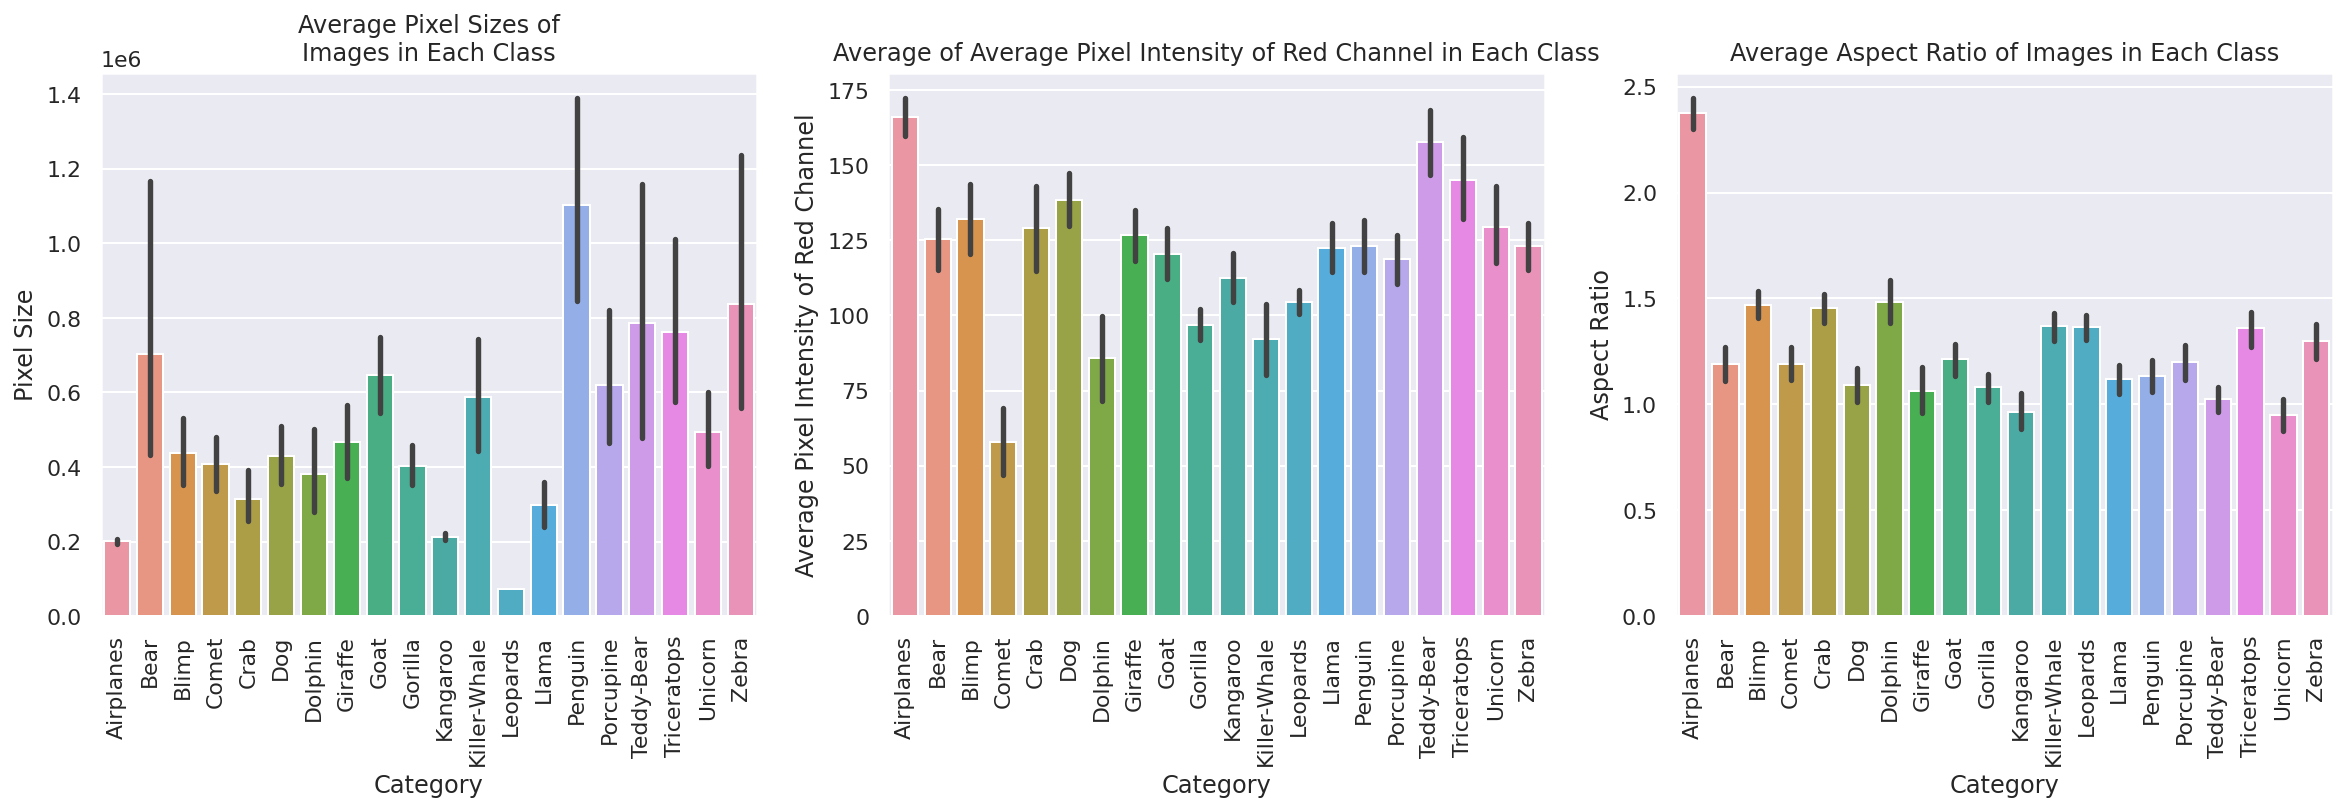

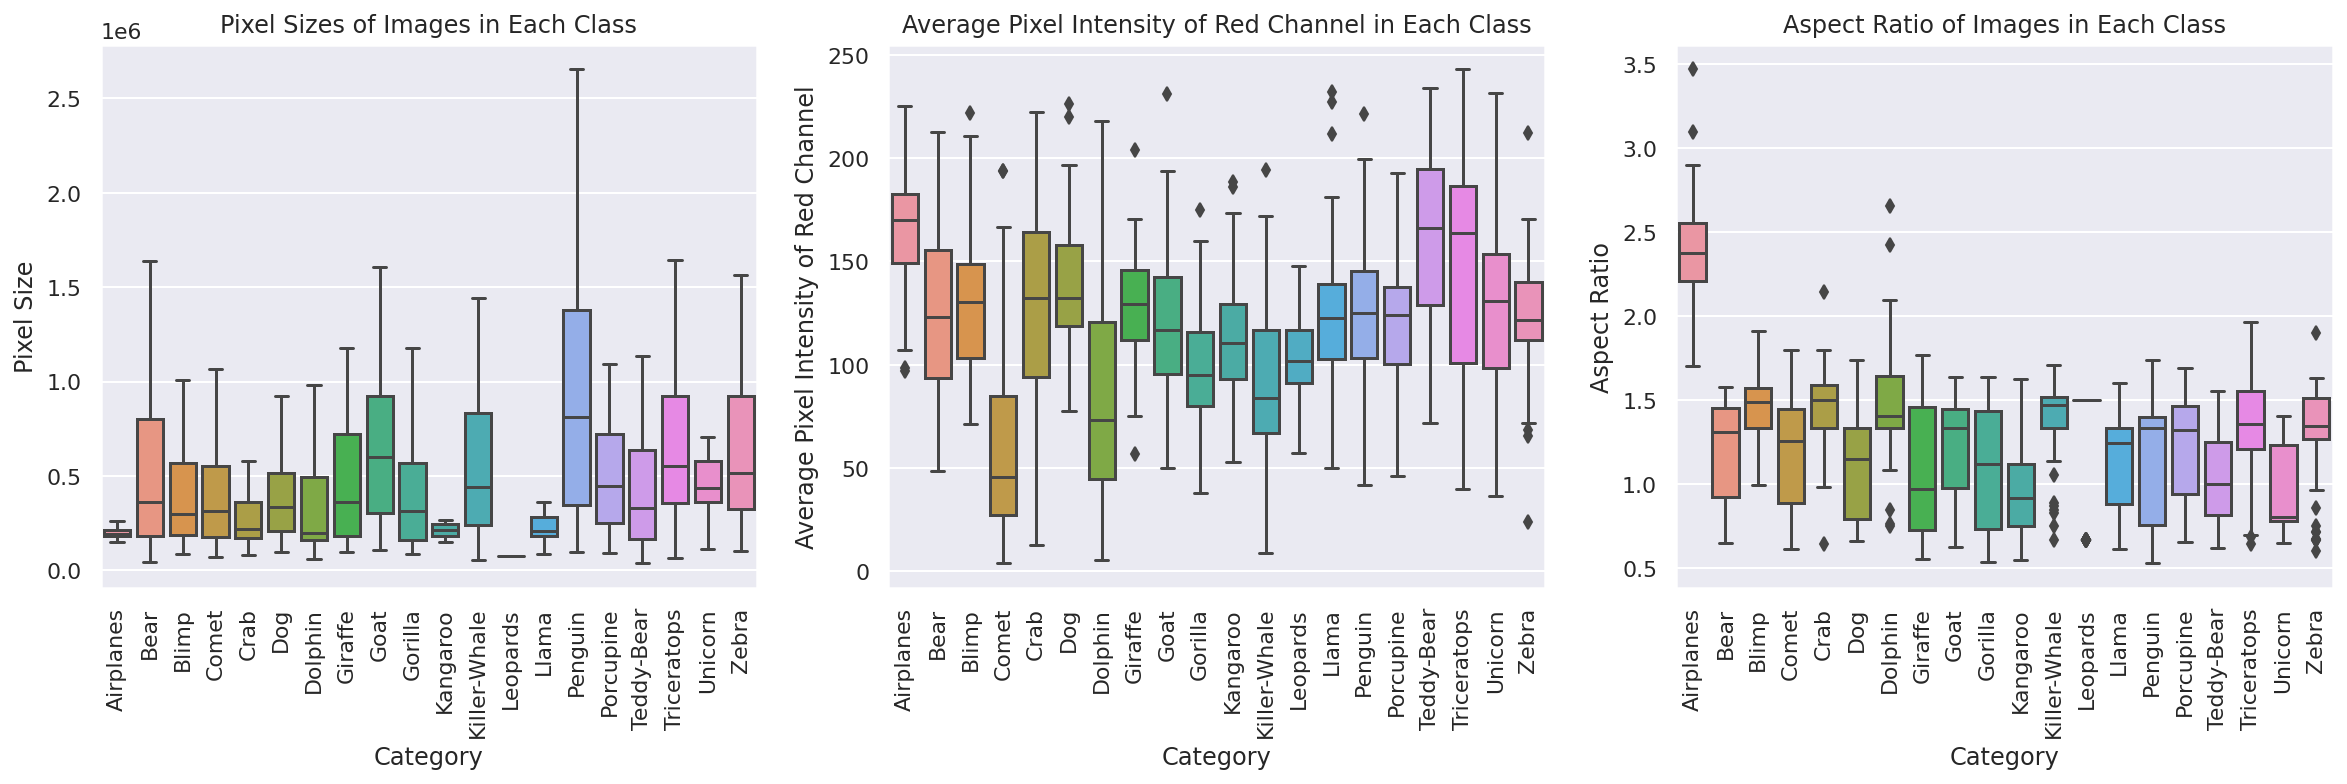

In [23]:
# Examing data distribution
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
g=sns.barplot(y=X_training['ft_size'], x=Y_training)
plt.ylabel('Pixel Size')
plt.xlabel('Category')
plt.title('Average Pixel Sizes of\nImages in Each Class')
g.set_xticklabels(class_names, rotation=90)

plt.subplot(1,3,2)
g=sns.barplot(y=X_training['ft_red_avg'], x=Y_training)
plt.ylabel('Average Pixel Intensity of Red Channel')
plt.xlabel('Category')
plt.title('Average of Average Pixel Intensity of Red Channel in Each Class')
g.set_xticklabels(class_names, rotation=90)

plt.subplot(1,3,3)
g=sns.barplot(y=X_training['ft_aspect_ratio'], x=Y_training)
plt.ylabel('Aspect Ratio')
plt.xlabel('Category')
plt.title('Average Aspect Ratio of Images in Each Class')
g.set_xticklabels(class_names, rotation=90);

plt.savefig('figures/summary_features_in_classes_barplot.png')

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
g=sns.boxplot(y=X_training['ft_size'], x=Y_training, showfliers=False)
plt.ylabel('Pixel Size')
plt.xlabel('Category')
plt.title('Pixel Sizes of Images in Each Class')
g.set_xticklabels(class_names, rotation=90)

plt.subplot(1,3,2)
g=sns.boxplot(y=X_training['ft_red_avg'], x=Y_training)
plt.ylabel('Average Pixel Intensity of Red Channel')
plt.xlabel('Category')
plt.title('Average Pixel Intensity of Red Channel in Each Class')
g.set_xticklabels(class_names, rotation=90)

plt.subplot(1,3,3)
g=sns.boxplot(y=X_training['ft_aspect_ratio'], x=Y_training)
plt.ylabel('Aspect Ratio')
plt.xlabel('Category')
plt.title('Aspect Ratio of Images in Each Class')
g.set_xticklabels(class_names, rotation=90);

plt.savefig('figures/summary_features_in_classes_boxplot.png')

From the barplot and boxplot, we can see that most pictures in classes like airplanes and leopards have fewer pictures compared to others. This phenomenon could be accidental, but if the images in the training and testing set are from the same source, these features could help us with the classification.

On the other hand, We can see that pictures belonging to the comet and killer whale categories have a low red-channel intensity on average. This could be explained by the dark sky and dark skin of the whales. Similarly, The large aspect ratio of images labeled as planes could be caused by the shape of the planes. These features are useful even outside our dataset! 

<h4> Sources </h4>

1. [OpenCV: Image Processing (imgproc module)](https://docs.opencv.org/4.4.0/d7/da8/tutorial_table_of_content_imgproc.html)
2. [OpenCV: Feature Detection and Description](https://docs.opencv.org/4.4.0/db/d27/tutorial_py_table_of_contents_feature2d.html)
3. [Image Classification using Python and Scikit-learn](https://gogul.dev/software/image-classification-python)
4. [Handwritten Digits Classification : An OpenCV ( C++ / Python ) Tutorial](https://www.learnopencv.com/handwritten-digits-classification-an-opencv-c-python-tutorial/)
5. [Bag of Visual Words in a Nutshell
](https://towardsdatascience.com/bag-of-visual-words-in-a-nutshell-9ceea97ce0fb)